Raphaël Bennaïm et Bastien Hoorelbeke

# Initiation aux réseaux de neurones, compétition à la mano.

In [73]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt# data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.image as mpimg
import math
from IPython.display import FileLink
import yaml
import random
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense, BatchNormalization, Rescaling, LeakyReLU,AveragePooling2D,RandomFlip,RandomRotation, Rescaling
from tensorflow.keras.models import load_model
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
num_classes = 10
SEED = 25
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTPUT_DIR = '/kaggle/working/outputs'
strategy = tf.distribute.MirroredStrategy()

Dans le but de pouvoir garder une trace des paramètres et hyperparamètres des modèles entrainés, un fichier `config.yml` est créé et les paramètres seront enregistrés au cours de l'exécution.

In [ ]:
def save_config(dictionnaire, chemin_fichier='config.yml'):
    with open(chemin_fichier, 'w') as fichier:
        yaml.dump(dictionnaire, fichier)
    print("Fichier YAML sauvegardé avec succès.")
def read_yaml(chemin_fichier):
    if os.path.exists(chemin_fichier):
        with open(chemin_fichier, 'r') as fichier:
            contenu = yaml.safe_load(fichier)
    else:
        contenu = {}
    return contenu

In [27]:
config = {}

In [28]:
config['output_file'] = 'submission.csv' 
config['BATCH_SIZE'] = 128 
config['model_file'] = 'best_model.h5'
config['epochs'] = 200 


## Affichage des images

In [25]:
directory_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data/"

In [ ]:
def get_subdirs(directory_path):
    return next(os.walk(directory_path))[1]
def get_files_list(directory_path):
    return next(os.walk(directory_path))[2]

In [ ]:

def display_images(directory_path,figsize=(8,8)):
    sub_dirlist = get_subdirs(directory_path)
    fig = plt.figure(figsize =figsize)
    cols,rows = 5,5
    for i in range(len(sub_dirlist)):
        sub_dir = sub_dirlist[i]
        full_path_dir = os.path.join(directory_path, sub_dir)
        img_path = random.choice(get_files_list(full_path_dir))
        img_path = os.path.join(full_path_dir,img_path)
        img = mpimg.imread(img_path)
        fig.add_subplot(rows,cols,i+1)
        plt.title(f'{sub_dir}')
        plt.imshow(img)  
    plt.show()
figsize=(16,16)
display_images(directory_path,figsize)

## Générer le dataset depuis les images

cf https://keras.io/api/data_loading/image/ et 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [35]:
ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(directory_path, labels='inferred',subset='both',shuffle=True,validation_split=0.2,seed=SEED,image_size=(16,24), batch_size=config['BATCH_SIZE'])
ds_train

Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Using 7103 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
ds_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Résultat à soumettre

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, patience=0,**kwargs):
        self.patience = patience
        self.counter = 0
        self.min_val_loss = float('inf')
        self.model_file_path = kwargs['model_file']
        

    def on_epoch_end(self, epoch, logs=None):
        
        val_loss = logs.get('val_loss')
        if (val_loss < self.min_val_loss):
            self.min_val_loss = val_loss
            print(f'\nNew Mininimum for validation loss: {self.min_val_loss}')
            print(f'Saving {self.model_file_path}, {epoch = }')
            self.model.save(os.path.join(self.model_file_path))

In [ ]:
class TimeOutCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, time_limit,**kwargs):
        self.beginning_time = time()
        self.time_limit = time_limit
        

    def on_epoch_end(self, epoch, logs=None):
        current_time = time()
        d_time = current_time - self.beginning_time
        if(d_time >= self.time_limit ):
            self.model.stop_training =True

            

In [ ]:
def test_phase(model):
    file_name = config['output_file']
    X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
    X_test = X_test.astype('float32')
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category":res})
    df.to_csv(os.path.join(file_name), index_label="Id")

def save_history(model,history):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"history.csv"
    history_df.to_csv(os.path.join(hist_file_name))

def save_model(model):
    model_file_name = f"{model.name}.h5"
    model.save(os.path.join(model_file_name))

## Créer le modèle

In [ ]:

def build_model(input_shape=(16, 24, 3), num_classes=10) -> Model:
    model = Sequential([
        
        Conv2D(128, 5, padding='same', input_shape=input_shape,activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.45),
        
        Conv2D(128, (3, 3), padding='same',activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(128, (3, 3), padding='same',activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.7),
        
        Flatten(),
        Dense(256,activation='relu'),
        LeakyReLU(alpha=0.6),
        BatchNormalization(),
        Dropout(0.675),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model
with strategy.scope():
    model = build_model()
config['model_config'] = model.get_config()
model.summary()

## Lancer le modèle

In [11]:
def plot_history(history=None,file_name=None):
    if file_name is None:
        history_df = pd.DataFrame(history.history)
    else:
        history_df = pd.read_csv(file_name)
    history_df[['val_accuracy', 'accuracy']].plot()
    plt.show()
    history_df[['loss','val_loss']].plot()
    plt.show()

In [36]:
BEST_MODEL_FILE_NAME = 'model.h5'
def train_and_test(model=None,**kwargs):
    callbacks = []
    epochs = kwargs['epochs']
    callbacks.append(MyCustomCallback(**kwargs))
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.8,verbose=1))
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_FILE_NAME,verbose=1,save_best_only=True))
    if model is None:
        model = build_model() 
    history = model.fit(ds_train,epochs=epochs,validation_data=ds_val,callbacks=callbacks)
    test_phase(model)
    save_model(model)
    save_history(model,history)
    return history

Entrainement du modèle

In [ ]:
history = train_and_test(model,**config)

Sauvegarde du modèle

### Analyse des résultats de l'entrainement

In [59]:
model = load_model(BEST_MODEL_FILE_NAME)

In [82]:
def get_confusion_matrix(model,ds_val):
    val_predictions = model.predict(ds_val)

    val_predicted_classes = tf.argmax(val_predictions, axis=1)

    val_true_classes = tf.concat([y for x, y in ds_val], axis=0)

    return confusion_matrix(val_true_classes, val_predicted_classes)
def display_confusion_matrix(val_confusion_matrix):
    # Matrice de confusion pour l'ensemble de validation
    plt.figure(figsize=(10, 8))
    sns.heatmap(val_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - Validation")
    plt.xlabel("Prédictions")
    plt.ylabel("Valeurs réelles")
    
    plt.show()

Calcul le la matrice de confusion

In [67]:
val_confusion_matrix = get_confusion_matrix(model,ds_val)

56/56 [==============================] - 12s 205ms/step


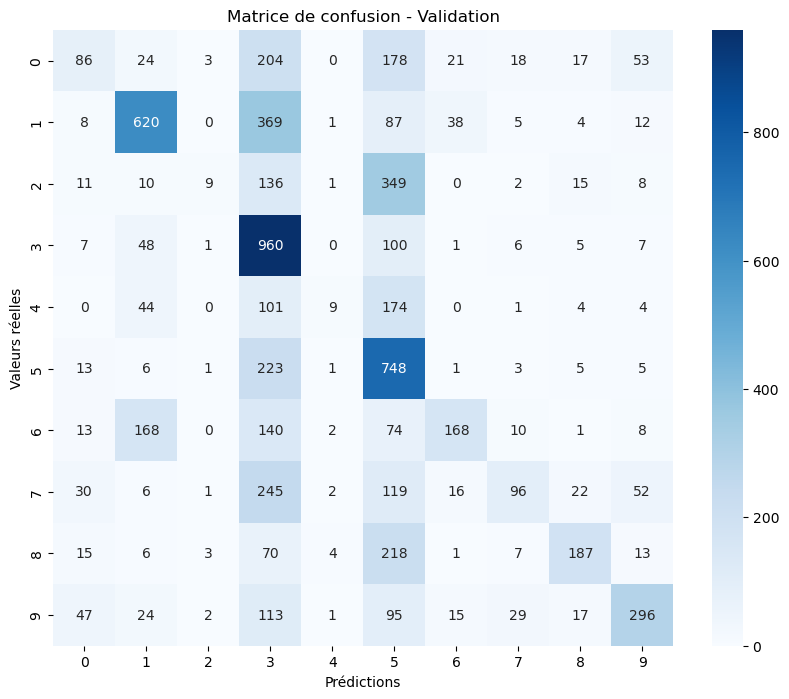

In [83]:
display_confusion_matrix(val_confusion_matrix)

Calcul des précisons et recall,



Nous allons ici afficher sous forme d'histogramme nos recall et précision pour chaque classe.

In [77]:
def precision_recall(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    
    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        
        precision[i] = TP / (TP + FP)
        recall[i] = TP / (TP + FN)

    return precision, recall
def plot_histogram(data, class_names, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, data)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

def compute_and_display_pr(val_confusion_matrix):
    class_names = [f'{i}' for i in range(num_classes)]
    val_precision, val_recall = precision_recall(val_confusion_matrix)
    plot_histogram(val_precision, class_names, "Précision de validation par classe", "Précision")
    plot_histogram(val_recall, class_names, "Rappel de validation par classe", "Rappel")

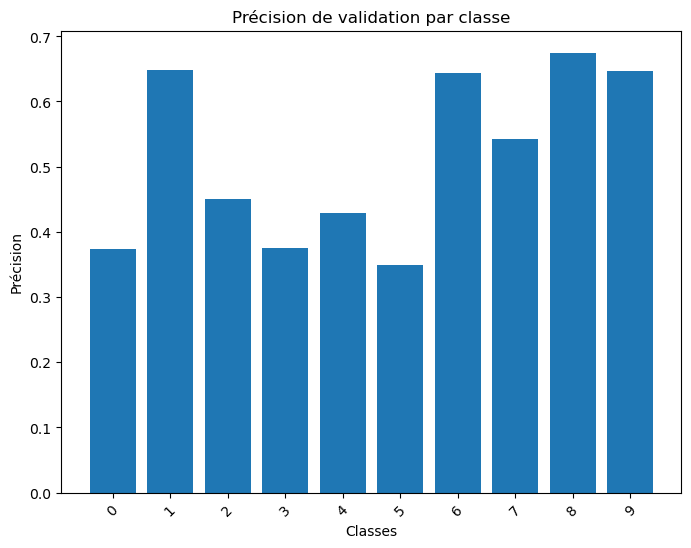

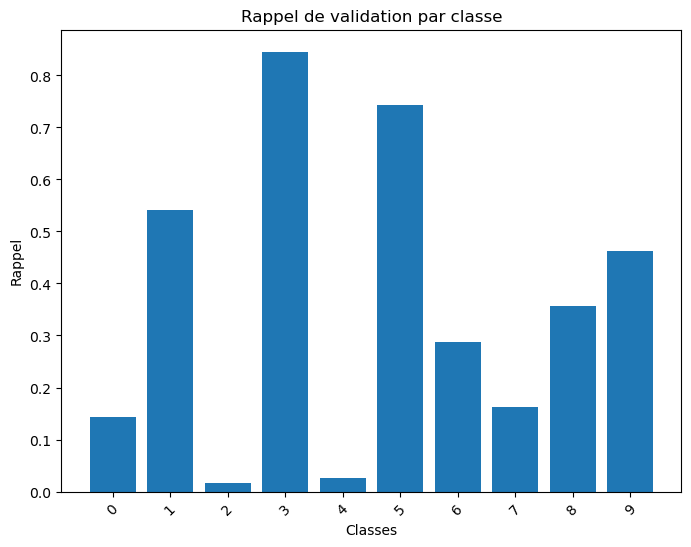

In [78]:
compute_and_display_pr(val_confusion_matrix)

#### Commentaires

La précision est une mesure de l'exactitude des prédictions positives du modèle, elle est ici comprise en tre 0.35 et 0.65 pour l'ensemble des classe, ce qui est insuffisant.

Le rappel,mesure la capacité du modèle à identifier correctement les échantillons positifs parmi tous les échantillons réellement positifs. Ici le rappel est très inégal le modèle a su identifier correctement les échantillons positifs des classes 3 et 5 avec une faible précision mais pas des 2 et 4, la généralisation du modèle n'est pas homogène.

Affichage de l'évolution des courbes.

In [ ]:
plot_history(history)

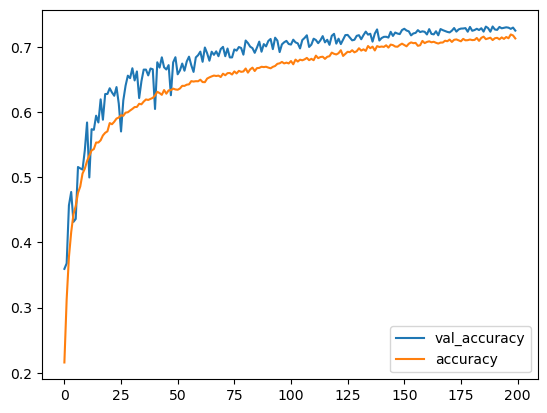

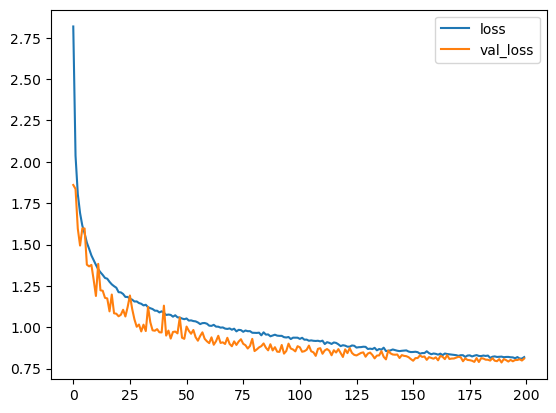

In [23]:
plot_history(file_name='history.csv')

### Commentaires sur les courbes

- Courbes d'accuracy:
    On peut remarquer que la val_accuracy est dans l'ensemble supérieure à l'accuracy, ce qui signifie que le réseau ne sur-apprend pas. Cependant l'accuracy converge vers 0.7 ce qui n'est pas suffisant.
- Courbes de loss:
    De la même manière la courbe de loss de la validation est dans l'ensemble inférieure cependant elle converge aux alentours de 0.8.

### Soumission des tests

In [ ]:
test_phase(model)
FileLink(config['output_file'])

In [ ]:
save_config(config,'config.yml')

In [ ]:
!rm -rf ships32/

In [84]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  20
